In [59]:
from similarityfunctions import *
import networkx as nx

In [63]:
dg = makeDirectedGraph(5, 3)

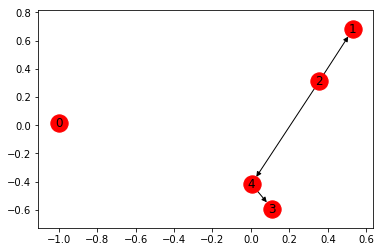

In [64]:
nx.draw_networkx(dg)

In [11]:
# add observations to a graph
def observeData(graph, true_nodes, false_nodes):
    for i in true_nodes:
        graph.nodes[i]['observed'] = True
    for i in false_nodes:
        graph.nodes[i]['observed'] = False

In [10]:
observeData(dg, [1, 4], [3])

In [11]:
dg.nodes.data()

NodeDataView({0: {}, 1: {'observed': True}, 2: {}, 3: {'observed': False}, 4: {'observed': True}})

In [12]:
# adds new true nodes and new false nodes to the graph and then checks for contradictions
# only finds direct contraidctions? Should talk with group about this.
import copy 
def findContradictions(graph, new_true_nodes, new_false_nodes, threshold=.5):
    new_g = copy.deepcopy(graph)
    observeData(new_g, new_true_nodes, new_false_nodes)
    edge_attrs = nx.get_edge_attributes(new_g, 'weight')
    for i in new_g.nodes():
        if 'observed' in new_g.nodes.data()[i]:
            if new_g.nodes.data()[i]['observed'] is True:
                for x in edge_attrs:
                    print(x, x[1], new_g.nodes.data()[x[1]], edge_attrs[x])
                    if 'observed' in new_g.nodes.data()[x[1]]:
                        if x[0] == i and new_g.nodes.data()[x[1]]['observed'] is False and edge_attrs[x] >= threshold:
                            return (i, True, x[1], False, edge_attrs[x])
    return "No contradictions found"

In [13]:
findContradictions(dg, [], [0])

(4, 0) 0 {'observed': False} 0.870339413846721
(4, 0) 0 {'observed': False} 0.870339413846721


(4, True, 0, False, 0.870339413846721)

In [7]:
def calibrateCPT(graph, CPT):
    pass

In [67]:
def getMarkovBlanket(graph, obs, hyp):
    #generates a new graph (markov blanket) based on the graph, observations, and hypothesis
    pass

## Criteria for Hypothesis
We want a hypothesis that is:
- Simple. As few nodes as possible.
- Probable. Should have a high probability of being true

In [ ]:
def calculateNodeProbability(graph, node, children):
    #calculate node probability given children
    p = 1
    for i in children:
        p *= children[i]
    graph
    return p*

In [1]:
# sees if some nodes are independent based on the nodes we are conditioning on
# we are only checking for *direct* conditions. chains are not accounted for
# since in baysien networks edges are "direct dependence." Should double-check this.
def independenceChecker(graph, conditions, nodes):
    edges = nx.get_edge_attributes(graph, 'weight')
    for i in edges:
        if i[1] in nodes and not i[0] in conditions:
            return False
    return True

In [56]:
def findHypotheses(graph, true_nodes, false_nodes):
    hyps = []
    for i in graph.nodes():
        children = get_all_children(graph, i, {}, 1)
        if all(item in children.keys() for item in true_nodes) and not any(item in children.keys() for item in false_nodes):
            hyps.append(i)
    return hyps

In [57]:
def findBestExplanation(graph, true_nodes, false_nodes):
    hyps = findHypothesis(graph, true_nodes, false_nodes)

In [65]:
findHypotheses(dg, [3], [])

[2, 4]